In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

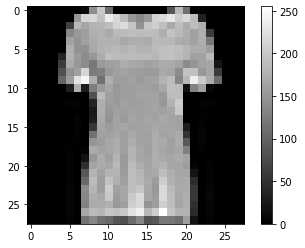

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

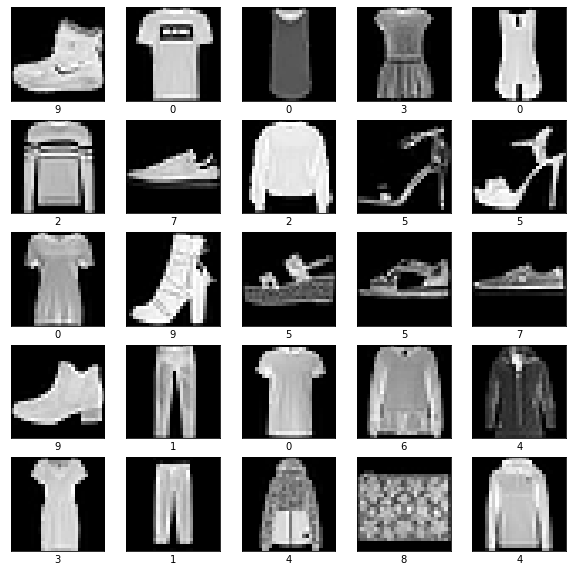

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

# Seleccionando tres clases

In [7]:
train_index = (train_labels==1) | (train_labels==3) | (train_labels==5)
test_index = (test_labels==1) | (test_labels==3) | (test_labels==5)

train_lab = train_labels[train_index]
test_lab = test_labels[test_index]

train_img = train_images[train_index]
test_img = test_images[test_index]

np.unique(train_lab)

array([1, 3, 5], dtype=uint8)

Relabeling de las clases a 0,1,2

In [8]:
lab_to_index = {
    1:0,
    3:1,
    5:2
}
lab_to_index[train_lab[0]]

1

In [9]:
train_idx_lab = np.array(list(map(lambda x: lab_to_index[x], train_lab)))
test_idx_lab = np.array(list(map(lambda x: lab_to_index[x], test_lab)))
train_idx_lab[0]

1

Diccionario de index a clase:


In [10]:
index_to_lab = {
    0: "Trouser",
    1: "Dress",
    2: "Sandal"
}
index_to_lab[lab_to_index[train_lab[0]]]

'Dress'

# Creacion de modelo

Definiendo hipotesis, error (cross entropy) y accuracy

In [11]:
def softmax(logits):
    exp_logits = tf.clip_by_value(tf.exp(logits), clip_value_min=tf.double.min/10, clip_value_max=tf.double.max/10)
    return exp_logits / tf.reduce_sum(exp_logits, 1, keepdims=True, name = "softmax_calculation")

In [12]:
def h(X):
    logits = tf.matmul(X, w, name="logits_calculation")
    return softmax(logits)

In [13]:
def cross_entropy(y_pred, y):
    y_sparse = tf.one_hot(y, depth=num_classes)
    y_sparse = tf.cast(y_sparse, tf.dtypes.float64)
    return tf.reduce_mean(-tf.reduce_sum(y_sparse * tf.math.log(y_pred+1e-15),1))

In [14]:
def accuracy(y_pred, y):
    y = tf.one_hot(y, depth=num_classes)
    y = tf.cast(y, tf.dtypes.float64)
    top_values, top_indices = tf.nn.top_k(y_pred, 1)
    class_pred = tf.cast(tf.greater_equal(y_pred, top_values), tf.float64)
    equality = tf.reduce_all(tf.equal(class_pred, y), axis=1)
    correct = tf.reduce_sum(tf.cast(equality, tf.float32))
    acc = correct/y.shape[0]
    return acc

Funcion que clasifica dado un set de probabilidades

In [15]:
def class_picker(y_probs):
    top_values, top_indices = tf.nn.top_k(y_probs, 1)
    return top_indices

Creando set de entrenamiento plano (no tomamos en cuenta relacion espacial de los features) y set de pesos w

In [16]:
num_classes = 3

In [17]:
shaped_train = train_img.reshape(train_img.shape[0], train_img.shape[1]*train_img.shape[2])
shaped_train_scaled = shaped_train/np.max(shaped_train) #Scaling, las imagenes van de 0 a 255, ahora de 0 a 1

shaped_train.shape

(18000, 784)

In [18]:
#El set de test se debe transformar de la misma manera que el set de entrenamiento para poder utilizar el contra este set
shaped_test = test_img.reshape(test_img.shape[0], test_img.shape[1]*test_img.shape[2])
shaped_test_scaled = shaped_test/np.max(shaped_test) #Normalizacion, las imagenes van de 0 a 255, ahora de 0 a 1

#Test tiene la particularidad de que necesita 785 features, pues se debe incluir la componente de bias como un 1
shaped_test = np.hstack((np.ones(shape=(shaped_test.shape[0],1)),shaped_test))
shaped_test_scaled = np.hstack((np.ones(shape=(shaped_test_scaled.shape[0],1)),shaped_test_scaled))

shaped_test.shape #784 features

(3000, 785)

In [19]:
w = tf.Variable(tf.random.truncated_normal([shaped_train.shape[1]+1, num_classes], dtype=tf.dtypes.double), name="weights")
w #Iniciializado con una distribucion normal de manera aleatoria, se agrega ademas el bias como feature

<tf.Variable 'weights:0' shape=(785, 3) dtype=float64, numpy=
array([[-0.65768891, -1.51429943, -0.18558118],
       [ 1.01689395,  0.21124592, -0.56652847],
       [ 0.5110595 ,  1.84027418, -1.09861491],
       ...,
       [ 0.17258996,  0.4031849 , -1.27105368],
       [ 1.37059355, -1.00800763, -1.06527224],
       [-1.300559  , -0.47084654,  0.68770746]])>

Creando funcion de entrenamiento

In [20]:
@tf.function
def softmax_train(X, y, epochs = 1000, lr = 0.001, batch_size = 32):
    #Necesitamos que X tenga el mismo shape que w, por lo que le añadimos una nueva columna de 1s
    #X = np.hstack((np.ones(shape=(x.shape[0],1)),x))
    #X = tf.constant(X, dtype=tf.dtypes.float64, shape = X)
    #y = tf.constant(y, dtype=tf.dtypes.int32, shape = y)
    
    error = tf.zeros((1,1), dtype=tf.dtypes.double)
    
    iterations = int(y.shape[0]/batch_size)
    step = 0
    for epoch in range(epochs):
        for i in range(iterations): 
            with tf.name_scope("batch_creation"):
                batch_start = i*batch_size
                batch_end = batch_start + batch_size
                X_b = X[batch_start:batch_end]
                y_b = y[batch_start:batch_end]
            
            with tf.name_scope("gradient_calc"):
                with tf.GradientTape() as grad_tape:
                    grad_tape.watch(w)
                    y_pred = h(X_b)
                    error = cross_entropy(y_pred, y_b)
                    
            with tf.name_scope("accuracy_calc"):
                acc = accuracy(y_pred, y_b)

            with tf.name_scope("parameter_updating"):
                grads_w = grad_tape.gradient(error,w)
                w.assign_sub(grads_w*lr)
                
            step = step + 1
            tf.summary.scalar('Cross-Entropy', error, step=step)
            tf.summary.scalar('Accuracy', acc, step=step)
            
    return w

In [21]:
tx = tf.convert_to_tensor(np.hstack((np.ones(shape=(shaped_train_scaled.shape[0],1)),shaped_train_scaled)), name="X")
ty = tf.convert_to_tensor(train_lab, name="y")
softmax_train(tx, ty, epochs = 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<tf.Tensor: shape=(785, 3), dtype=float64, numpy=
array([[-0.67769604, -1.48672003, -0.19315345],
       [ 1.01689395,  0.21124592, -0.56652847],
       [ 0.5110595 ,  1.84027418, -1.09861491],
       ...,
       [ 0.17257692,  0.40319794, -1.27105368],
       [ 1.37058937, -1.00800306, -1.06527264],
       [-1.300559  , -0.47084654,  0.68770746]])>

In [22]:
#Las sumas de las probabilidades predichas para cada clase y cada observacion es 1 (o muy cercano a 1)
tf.reduce_min(tf.reduce_sum(h(shaped_test), 1)), tf.reduce_max(tf.reduce_sum(h(shaped_test), 1)), 

(<tf.Tensor: shape=(), dtype=float64, numpy=0.9999999999999999>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.0000000000000002>)

In [23]:
h(shaped_test)

<tf.Tensor: shape=(3000, 3), dtype=float64, numpy=
array([[0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       ...,
       [            nan,             nan,             nan],
       [            nan,             nan,             nan],
       [7.37474926e-234, 1.00000000e+000, 0.00000000e+000]])>

In [24]:
np.array(list(map(lambda x: index_to_lab[x[0]], class_picker(h(shaped_test)).numpy())))

array(['Dress', 'Dress', 'Dress', ..., 'Trouser', 'Trouser', 'Dress'],
      dtype='<U7')

# Creando grafo

In [25]:
del(w)
w = tf.Variable(tf.random.truncated_normal([shaped_train.shape[1]+1, num_classes], dtype=tf.dtypes.double), name="weights")
tx = tf.convert_to_tensor(np.hstack((np.ones(shape=(shaped_train_scaled.shape[0],1)),shaped_train_scaled)), name="X")
ty = tf.convert_to_tensor(train_lab, name="y")

#Creando grafo
logdir = f'logs\\sm_bs={shaped_train.shape[0]}_lr={0.001}_epochs={1}'
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():
    tf.summary.trace_on(graph=True, profiler=False)
    final_params = softmax_train(tx, ty, epochs = 1, batch_size = shaped_train.shape[0])
    tf.summary.trace_export(
                          name="model_graph",
                          step=0,
                          profiler_outdir="logs\\modelgraph")
writer.flush()
final_params

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


<tf.Tensor: shape=(785, 3), dtype=float64, numpy=
array([[-0.0270388 ,  0.92837163, -0.09925492],
       [ 1.07957287, -0.06634209, -0.05809029],
       [ 1.66749176, -0.98502739, -0.33055447],
       ...,
       [ 0.15380356,  0.70258241, -0.44017621],
       [-0.23983876,  0.59566831, -0.07331063],
       [-1.43379188, -1.52254365, -0.02737659]])>

![alt text](graph.PNG "Grafo")

# Creando modelos con data cruda y escalada

In [26]:
#Data escalada
tf.config.run_functions_eagerly(True)
del(w)
w = tf.Variable(tf.random.truncated_normal([shaped_train.shape[1]+1, num_classes], dtype=tf.dtypes.double), name="weights")
tx = tf.convert_to_tensor(np.hstack((np.ones(shape=(shaped_train_scaled.shape[0],1)),shaped_train_scaled)), name="X")
ty = tf.convert_to_tensor(train_lab, name="y")

logdir = f'logs\\sm_scaled_bs=32_lr=0.001_epochs=100'
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():
    scaled_params = softmax_train(tx, ty, epochs = 100)
writer.flush()

#Data cruda
del(w)
w = tf.Variable(tf.random.truncated_normal([shaped_train.shape[1]+1, num_classes], dtype=tf.dtypes.double), name="weights")
tx = tf.convert_to_tensor(np.hstack((np.ones(shape=(shaped_train.shape[0],1)),shaped_train)), name="X")
ty = tf.convert_to_tensor(train_lab, name="y")

logdir = f'logs\\sm_raw_bs=32_lr=0.001_epochs=100'
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():
    raw_params = softmax_train(tx, ty, epochs = 100)
writer.flush()

In [28]:
scaled_params, raw_params

(<tf.Variable 'weights:0' shape=(785, 3) dtype=float64, numpy=
 array([[ 0.09077619,  1.81841609, -0.50062358],
        [ 0.75652027, -1.58537129,  1.07963241],
        [ 0.19374221,  1.15405539, -0.62986674],
        ...,
        [-1.25784488, -1.04337431,  0.03750204],
        [ 0.34874806, -1.12407447,  0.04537094],
        [-0.61050711,  1.40820242, -0.0893723 ]])>,
 <tf.Variable 'weights:0' shape=(785, 3) dtype=float64, numpy=
 array([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])>)

Podemos ver que la data cruda no produce resultados

![alt text](acc.PNG "Accuracy")

![alt text](error.PNG "cross_entropy")

Podemos observar que, a pesar de que existe una tendencia de reduccion en el error de cross entropy, el accuracy no es particularmente alto pero si es bastante inestable en cada batch

# Prediciendo con graficas

In [42]:
#Se necesita que los pesos sean los generados al entrenar con la data transformada
w = scaled_params

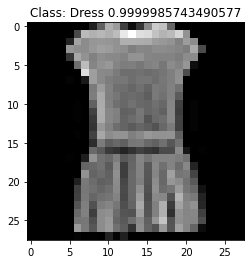

In [78]:
def img_classifier(image):
    image_flattened = image.reshape(1,-1)
    image_normalized = image_flattened/np.max(shaped_train)
    image_proc = np.hstack((np.ones(shape=(1,1)),image_normalized)) #Se debe realizar la transformacion
    preds = h(image_proc)
    tfindex = tf.math.argmax(preds, 1)
    index = tfindex.numpy()[0]
    prob = tf.reduce_max(preds).numpy()
    
    predicted_class = index_to_lab[index]
    
    plt.title(f"Class: {predicted_class} {prob}")
    plt.imshow(image, cmap = 'gray')

img_classifier(train_img[0])

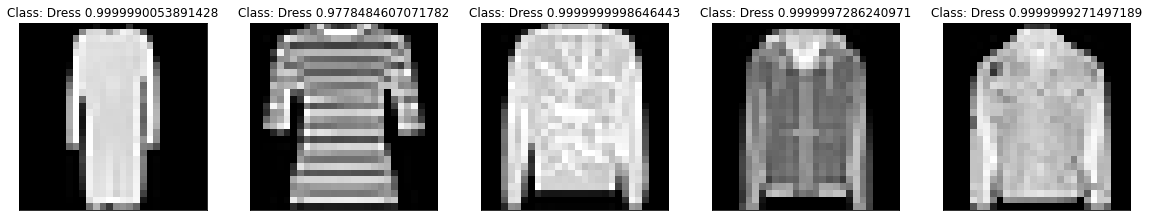

In [85]:
plt.figure(figsize=(20,20))

for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(train_images[i], cmap='gray')
    #plt.xlabel(train_labels[i])
    img_classifier(train_images[i+25])
plt.show()

In [86]:
h(shaped_test)[10:20]

<tf.Tensor: shape=(10, 3), dtype=float64, numpy=
array([[5.00000000e-001, 5.00000000e-001, 0.00000000e+000],
       [9.88599586e-151, 1.00000000e+000, 0.00000000e+000],
       [2.45970769e-066, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [5.00000000e-001, 5.00000000e-001, 0.00000000e+000],
       [2.87335206e-237, 1.00000000e+000, 0.00000000e+000],
       [5.00000000e-001, 5.00000000e-001, 5.89014667e-081],
       [1.00000000e+000, 7.26131473e-067, 2.15986720e-157],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000]])>